In [20]:
# Tugas 1: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.

from pyspark.sql import SparkSession

# Membuat Spark session
spark = SparkSession.builder.appName("BasicSparkSQL").getOrCreate()

# Membuat data baru
data = [
    ('Septiana', 25, 'F', 4200, 1),
    ('Diyah', 29, 'F', 3900, 2),
    ('Ayu', 24, 'F', 3100, 1),
    ('Wulandari', 27, 'F', 4500, 2)
]

# Kolom
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

# Membuat DataFrame dari data di atas
df = spark.createDataFrame(data, schema=columns)

# Menampilkan isi DataFrame
print("Isi DataFrame")
df.show()

# Membuat Temporary View untuk SQL
df.createOrReplaceTempView('employees')

# Query 1: Menampilkan semua data
print("Semua data")
spark.sql('SELECT * FROM employees').show()

# Query 2: Menampilkan nama dan umur karyawan dengan gaji > 4000
print("Nama dan umur karyawan dengan gaji > 4000")
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 4000').show()

# Query 3: Menghitung rata-rata gaji karyawan
print("Menghitung rata-rata gaji karyawan")
spark.sql('SELECT AVG(Salary) AS Average_Salary FROM employees').show()

Isi DataFrame
+---------+---+------+------+------+
|     Name|Age|Gender|Salary|DeptId|
+---------+---+------+------+------+
| Septiana| 25|     F|  4200|     1|
|    Diyah| 29|     F|  3900|     2|
|      Ayu| 24|     F|  3100|     1|
|Wulandari| 27|     F|  4500|     2|
+---------+---+------+------+------+

Semua data
+---------+---+------+------+------+
|     Name|Age|Gender|Salary|DeptId|
+---------+---+------+------+------+
| Septiana| 25|     F|  4200|     1|
|    Diyah| 29|     F|  3900|     2|
|      Ayu| 24|     F|  3100|     1|
|Wulandari| 27|     F|  4500|     2|
+---------+---+------+------+------+

Nama dan umur karyawan dengan gaji > 4000
+---------+---+
|     Name|Age|
+---------+---+
| Septiana| 25|
|Wulandari| 27|
+---------+---+

Menghitung rata-rata gaji karyawan
+--------------+
|Average_Salary|
+--------------+
|        3925.0|
+--------------+



In [6]:
# TUGAS 2: Menghitung total gaji berdasarkan jenis kelamin dan usia
print("Total Gaji Berdasarkan Gender dan Usia")
spark.sql('''
SELECT Gender,
       Age,
       SUM(Salary) AS TotalSalary
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

# TUGAS TAMBAHAN 2
# Mencari rata-rata gaji per departemen
print("Rata-Rata Gaji per Departemen")
spark.sql('''
SELECT DeptId,
       AVG(Salary) AS Average_Salary
FROM employees
GROUP BY DeptId
''').show()

# Menemukan karyawan dengan gaji di atas rata-rata masing-masing gender
print("Karyawan dengan Gaji di Atas Rata-Rata per Gender")
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
) g
ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
''').show()

# Membuat ranking karyawan berdasarkan gaji dalam departemen
print("Ranking Gaji Berdasarkan Departemen")
spark.sql('''
SELECT Name, DeptId, Salary,
       RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Salary_Rank
FROM employees
''').show()

Total Gaji Berdasarkan Gender dan Usia
+------+---+-----------+
|Gender|Age|TotalSalary|
+------+---+-----------+
|     F| 24|       3100|
|     F| 25|       4200|
|     F| 27|       4500|
|     F| 29|       3900|
+------+---+-----------+

Rata-Rata Gaji per Departemen
+------+--------------+
|DeptId|Average_Salary|
+------+--------------+
|     1|        3650.0|
|     2|        4200.0|
+------+--------------+

Karyawan dengan Gaji di Atas Rata-Rata per Gender
+---------+------+------+
|     Name|Gender|Salary|
+---------+------+------+
| Septiana|     F|  4200|
|Wulandari|     F|  4500|
+---------+------+------+

Ranking Gaji Berdasarkan Departemen
+---------+------+------+-----------+
|     Name|DeptId|Salary|Salary_Rank|
+---------+------+------+-----------+
| Septiana|     1|  4200|          1|
|      Ayu|     1|  3100|          2|
|Wulandari|     2|  4500|          1|
|    Diyah|     2|  3900|          2|
+---------+------+------+-----------+



In [7]:
# TUGAS 3: Menggunakan window function untuk menemukan top 3 gaji tertinggi per kelompok usia
print("TOP 3 Karyawan Berdasarkan Gaji Tertinggi per Kelompok Usia")
spark.sql('''
SELECT Name,
       Age,
       Salary,
       ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) AS Rank
FROM employees
''').createOrReplaceTempView('ranked_employees')

# Menampilkan hanya Top 3 dari setiap kelompok usia
spark.sql('''
SELECT * FROM ranked_employees
WHERE Rank <= 3
ORDER BY Age, Rank
''').show()

TOP 3 Karyawan Berdasarkan Gaji Tertinggi per Kelompok Usia
+---------+---+------+----+
|     Name|Age|Salary|Rank|
+---------+---+------+----+
|      Ayu| 24|  3100|   1|
| Septiana| 25|  4200|   1|
|Wulandari| 27|  4500|   1|
|    Diyah| 29|  3900|   1|
+---------+---+------+----+



In [8]:
# Tugas 4: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.
from pyspark.sql import SparkSession

# Membuat Spark session
spark = SparkSession.builder.appName("Pertemuan9").getOrCreate()

# Dataset
employees = spark.createDataFrame([
    ('Septiana', 30, 'F', 5000, 1),
    ('Diyah', 28, 'F', 4500, 2),
    ('Ayu', 35, 'F', 5200, 1),
    ('Wulandari', 27, 'F', 3900, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

projects = spark.createDataFrame([
    (1, 'Project Alpha'),
    (2, 'Project Beta')
], ['DeptId', 'ProjectName'])

# Register temporary views
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Query Join 3 tabel (employees, departments, projects)
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
ORDER BY e.Salary DESC
''').show()

25/10/24 17:29:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

+---------+---+------+---------+-------------+
|     Name|Age|Salary| DeptName|  ProjectName|
+---------+---+------+---------+-------------+
|      Ayu| 35|  5200|       HR|Project Alpha|
| Septiana| 30|  5000|       HR|Project Alpha|
|    Diyah| 28|  4500|Marketing| Project Beta|
|Wulandari| 27|  3900|Marketing| Project Beta|
+---------+---+------+---------+-------------+



In [9]:
# Tugas 5: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
# Rata-rata gaji per departemen
print("Rata-rata gaji per departemen")
spark.sql('''
SELECT d.DeptName, AVG(e.Salary) AS AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
''').show()

# Ranking karyawan berdasarkan gaji di tiap departemen
print("Ranking karyawan berdasarkan gaji di tiap departemen")
spark.sql('''
SELECT e.Name, d.DeptName, e.Salary,
       RANK() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) AS Rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

Rata-rata gaji per departemen
+---------+---------+
| DeptName|AvgSalary|
+---------+---------+
|       HR|   5100.0|
|Marketing|   4200.0|
+---------+---------+

Ranking karyawan berdasarkan gaji di tiap departemen
+---------+---------+------+----+
|     Name| DeptName|Salary|Rank|
+---------+---------+------+----+
|      Ayu|       HR|  5200|   1|
| Septiana|       HR|  5000|   2|
|    Diyah|Marketing|  4500|   1|
|Wulandari|Marketing|  3900|   2|
+---------+---------+------+----+



In [10]:
# Tugas 6: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.
print("Tren gaji berdasarkan usia di setiap departemen")
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptName,
       AVG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS TrendSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, e.Age
''').show()

Tren gaji berdasarkan usia di setiap departemen
+---------+---+------+---------+-----------+
|     Name|Age|Salary| DeptName|TrendSalary|
+---------+---+------+---------+-----------+
| Septiana| 30|  5000|       HR|     5000.0|
|      Ayu| 35|  5200|       HR|     5100.0|
|Wulandari| 27|  3900|Marketing|     3900.0|
|    Diyah| 28|  4500|Marketing|     4200.0|
+---------+---+------+---------+-----------+



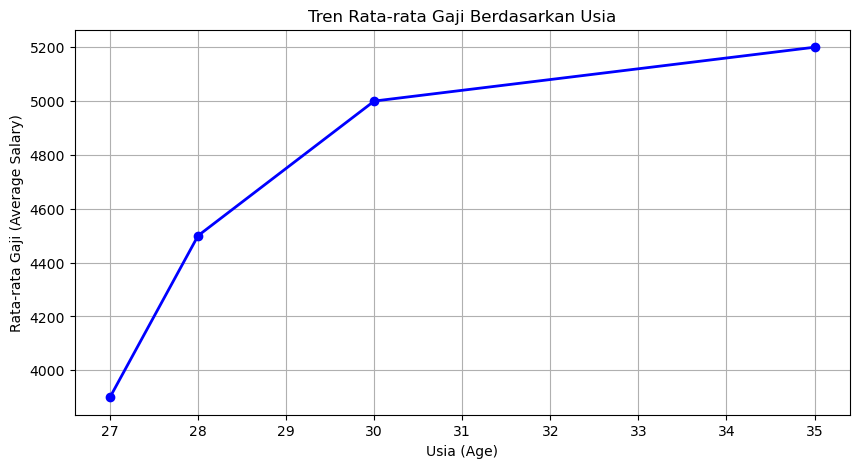

In [11]:
# Tugas 7: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.
# Import library
import matplotlib.pyplot as plt
import pandas as pd

# Analisis tren gaji berdasarkan usia menggunakan Spark SQL
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualisasi hasil analisis tren gaji
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o', color='blue', linewidth=2)
plt.xlabel('Usia (Age)')
plt.ylabel('Rata-rata Gaji (Average Salary)')
plt.title('Tren Rata-rata Gaji Berdasarkan Usia')
plt.grid(True)
plt.show()

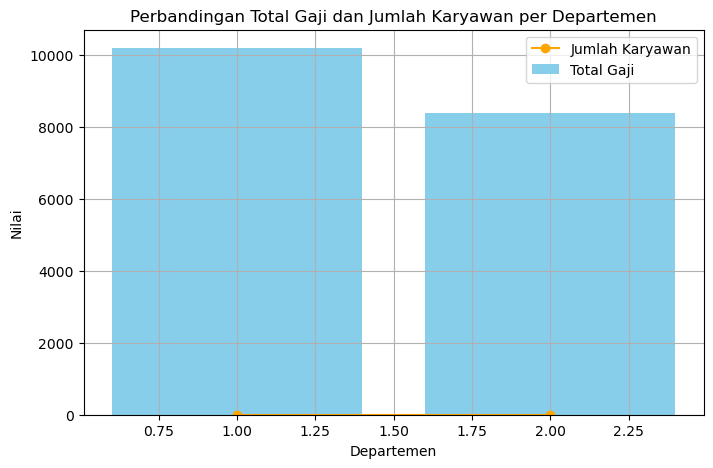

In [12]:
# Tugas 1: Total gaji dan jumlah karyawan per departemen
dept_summary = spark.sql('''
SELECT DeptId, 
       SUM(Salary) AS TotalSalary, 
       COUNT(Name) AS TotalEmployees
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').toPandas()

# Visualisasi perbandingan antar departemen
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(dept_summary['DeptId'], dept_summary['TotalSalary'], color='skyblue', label='Total Gaji')
plt.plot(dept_summary['DeptId'], dept_summary['TotalEmployees'], color='orange', marker='o', label='Jumlah Karyawan')
plt.xlabel('Departemen')
plt.ylabel('Nilai')
plt.title('Perbandingan Total Gaji dan Jumlah Karyawan per Departemen')
plt.legend()
plt.grid(True)
plt.show()

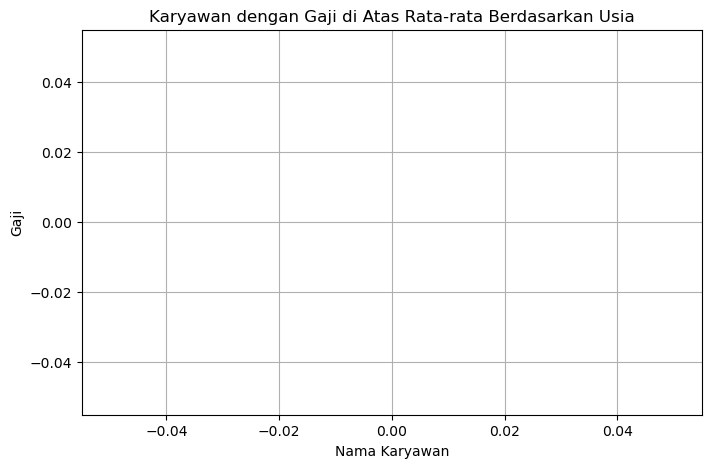

In [13]:
# Tugas 2: Karyawan dengan gaji di atas rata-rata untuk kelompok usia masing-masing
above_avg_salary = spark.sql('''
SELECT e.Name, e.Age, e.Salary
FROM employees e
JOIN (
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
) avg_table
ON e.Age = avg_table.Age
WHERE e.Salary > avg_table.AvgSalary
ORDER BY e.Age
''').toPandas()

# Visualisasi data
plt.figure(figsize=(8,5))
plt.bar(above_avg_salary['Name'], above_avg_salary['Salary'], color='green')
plt.xlabel('Nama Karyawan')
plt.ylabel('Gaji')
plt.title('Karyawan dengan Gaji di Atas Rata-rata Berdasarkan Usia')
plt.grid(True)
plt.show()

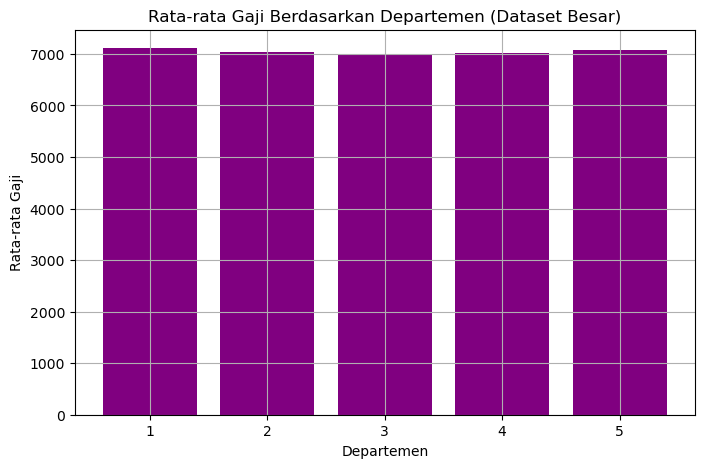

In [18]:
# Tugas 3: Dataset Besar dan Analisis Lanjutan
# Contoh dataset besar (disimulasikan)
# Dataset besar (150 baris)
data_large = [
    (f'Karyawan_{i}', 
     20 + (i % 15),              # Usia bervariasi antara 20–34 tahun
     'F' if i % 2 == 0 else 'M', # Jenis kelamin bergantian
     2500 + (i * 45),            # Gaji bertambah tiap karyawan
     (i % 5) + 1                 # DeptId antara 1–5
    )
    for i in range(1, 202)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df_large = spark.createDataFrame(data_large, schema=columns)
df_large.createOrReplaceTempView('employees_large')

# Analisis mendalam menggunakan fungsi SQL
analysis = spark.sql('''
SELECT DeptId,
       AVG(Salary) AS AvgSalary,
       SUM(Salary) AS TotalSalary,
       COUNT(Name) AS TotalEmployees
FROM employees_large
GROUP BY DeptId
ORDER BY AvgSalary DESC
''').toPandas()

# Visualisasi
plt.figure(figsize=(8,5))
plt.bar(analysis['DeptId'], analysis['AvgSalary'], color='purple')
plt.xlabel('Departemen')
plt.ylabel('Rata-rata Gaji')
plt.title('Rata-rata Gaji Berdasarkan Departemen (Dataset Besar)')
plt.grid(True)
plt.show()